In [1]:
using LightGraphs, MetaGraphs, CSV, DataFrames, GraphDataFrameBridge

In [2]:
using GraphPlot, LinearAlgebra, Plots
BLAS.set_num_threads(10)
using Statistics

In [3]:
using StatsPlots

In [4]:
file = "../data/interim/costanzo_pcc_ALL"

"../data/interim/costanzo_pcc_ALL"

In [5]:
df = CSV.read(file);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `CSV.read(input, DataFrame; kw...)
└ @ CSV /home/oma21/.julia/packages/CSV/fOEbk/src/CSV.jl:41


In [6]:
mg = MetaGraph(df, :gene1, :gene2);

In [7]:
gc, vmap = induced_subgraph(mg, connected_components(mg)[1]);

In [8]:
function get_gnm(gc,no_zeros=true)
    L = laplacian_matrix(gc)
    f = eigen(Matrix(L))
    if no_zeros
        vals = f.values[2:length(f.values)];
        vecs = f.vectors[:, 2:length(f.values)];
    else
        vals = f.values
        vecs = f.vectors
    end
    return vals, vecs
end
function get_prs(v, w)
    D = 1 ./ v
    cov = w*(Diagonal(D) * w');
    prs_mat = cov.^2;
    prs_mat_diag = diag(prs_mat);
    prs_mat_norm = prs_mat ./ prs_mat_diag'; 
    eff = sum(prs_mat_norm, dims = 1)';
    sens = sum(prs_mat_norm, dims = 2);
    
    return prs_mat_norm, eff, sens
end  

get_prs (generic function with 1 method)

In [9]:
v, w = get_gnm(gc);
prs_mat , eff , sens = get_prs(v, w);

In [10]:
using StaticGraphs
sgc = StaticGraph(gc.graph)

{5183, 39816} undirected simple static {UInt16, UInt32} graph

In [11]:
start = time()
paths = zeros(5183,5183);
for i in 1:nv(gc)
    paths[i,:]=dijkstra_shortest_paths(sgc, i).dists
end
elapsed = time() - start
println(elapsed)

11.720755100250244


In [16]:
nodelist = Dict([(i, props(gc,i)[:name]) for i in 1:nv(gc)]);


In [24]:
onedeg_nodes = findall(x->x==1,degree(gc));
others = findall(x->x!=1,degree(gc));

In [18]:
paths[diagind(paths)] .= Inf;

In [25]:
p1=convert(Array{Int16},minimum(paths[others,onedeg_nodes],dims=2));

In [26]:
p1_counts = [count(i->(i== j), p1) for j in 1:maximum(p1)];


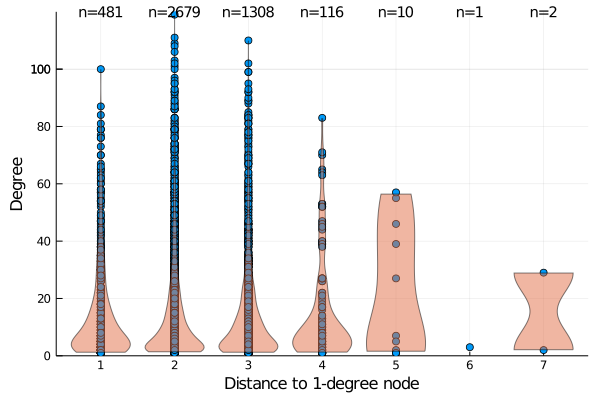

In [28]:
boxplot(p1,(degree(gc)),legend=false)
violin!(p1,(degree(gc)),alpha=0.5)
annotate!([(i,120, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
ylims!(0,120)
xlabel!("Distance to 1-degree node")
ylabel!("Degree")
#png("../reports/figures/pcc_prs_0722/degree_dist1.png")

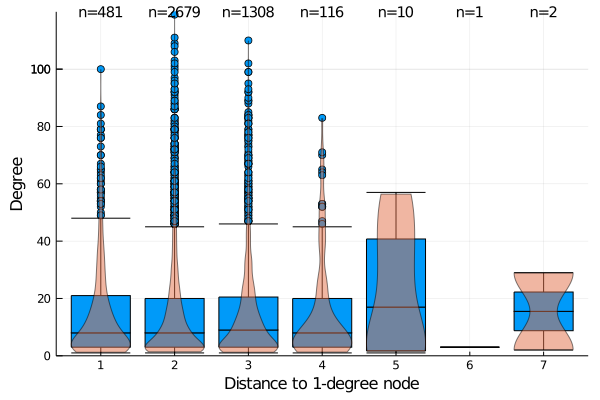

In [27]:
boxplot(p1,(degree(gc)),legend=false)
violin!(p1,(degree(gc)),alpha=0.5)
annotate!([(i,120, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
ylims!(0,120)
xlabel!("Distance to 1-degree node")
ylabel!("Degree")
#png("../reports/figures/pcc_prs_0722/degree_dist1.png")

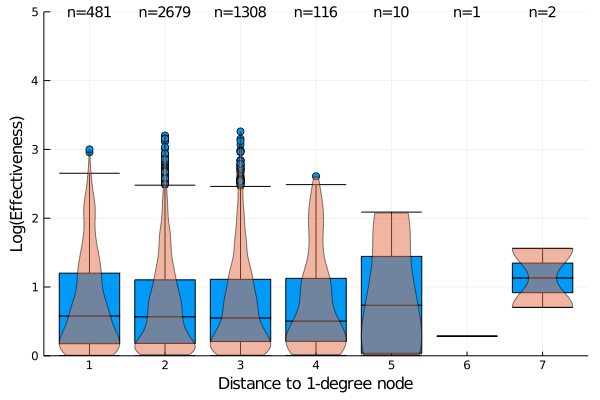

In [31]:
boxplot(p1,log.(eff),legend=false)
violin!(p1,log.(eff),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
ylims!(0,5)
xlabel!("Distance to 1-degree node")
ylabel!("Log(Effectiveness)")
#png("../reports/figures/pcc_prs_0722/eff_dist1.png")

In [33]:
sens= sens[:];

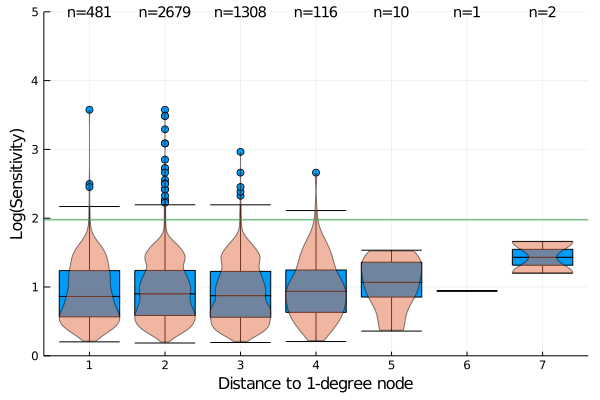

In [34]:
boxplot(p1,log.(sens),legend=false)
violin!(p1,log.(sens),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p1_counts[i])",10)) for i in 1:length(p1_counts) ]) 
hline!([Statistics.quantile!(log.(sens),0.99)])
ylims!(0,5)
xlabel!("Distance to 1-degree node")
ylabel!("Log(Sensitivity)")
#png("../reports/figures/pcc_prs_0722/sens_dist1.png")


In [24]:
twodeg_nodes = findall(x->x==2,degree(gc));
p2 = minimum(paths[:,twodeg_nodes],dims=2);
p2_counts = [count(i->(i== j), p2) for j in 1:maximum(p2)];

In [26]:
boxplot(p2,(degree(gc)),legend=false)
violin!(p2,(degree(gc)),alpha=0.5)
annotate!([(i,120, Plots.text("n=$(p2_counts[i])",10)) for i in 1:length(p2_counts) ]) 
ylims!(0,120)
xlabel!("Distance to 2-degree node")
ylabel!("Degree")
#png("../reports/figures/pcc_prs_0722/degree_dist2.png")

In [27]:
boxplot(p2,log.(eff),legend=false)
violin!(p2,log.(eff),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p2_counts[i])",10)) for i in 1:length(p2_counts) ]) 
ylims!(0,5)
xlabel!("Distance to 2-degree node")
ylabel!("Log(Effectiveness)")
png("../reports/figures/pcc_prs_0722/eff_dist2.png")

In [28]:
boxplot(p2,log.(sens),legend=false)
violin!(p2,log.(sens),alpha=0.5)
annotate!([(i,5, Plots.text("n=$(p2_counts[i])",10)) for i in 1:length(p2_counts) ]) 
hline!([Statistics.quantile!(log.(sens),0.99)])
ylims!(0,5)
xlabel!("Distance to 2-degree node")
ylabel!("Log(Sensitivity)")
png("../reports/figures/pcc_prs_0722/sens_dist2.png")
#png("../reports/figures/sens_dist")